In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import mean_absolute_percentage_error, huber
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_segmented = pd.read_excel("data/sales.xlsx")

df_segmented['timestamp'] = pd.to_datetime(df_segmented['transaction_date'].astype(str) + ' ' + df_segmented['transaction_time'].astype(str))

df_segmented['revenue'] = df_segmented['transaction_qty'] * df_segmented['unit_price']

df_segmented.drop(columns=['transaction_date', 'transaction_time'], inplace=True)

df_segmented.set_index('timestamp', inplace=True)

df_segmented = df_segmented.groupby(['store_location', 'product_category']) \
    .resample('D') \
    .agg({
        'revenue': 'sum',
        'transaction_qty': 'sum'
    }).reset_index()

df_segmented['year'] = df_segmented['timestamp'].dt.year
df_segmented['month'] = df_segmented['timestamp'].dt.month
df_segmented['day'] = df_segmented['timestamp'].dt.day
df_segmented['dayofweek'] = df_segmented['timestamp'].dt.dayofweek
df_segmented['is_weekend'] = df_segmented['dayofweek'].isin([5, 6]).astype(int)
df_segmented['weekofyear'] = df_segmented['timestamp'].dt.isocalendar().week

df_segmented['revenue_lag1'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(1)
df_segmented['revenue_lag7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(7)
df_segmented['revenue_lag30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(30)

df_segmented['rolling_mean_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df_segmented['rolling_std_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).std())
df_segmented['rolling_mean_30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=30).mean())

df_segmented['cumulative_revenue'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].cumsum()

df_segmented = pd.get_dummies(df_segmented, columns=['store_location', 'product_category'], drop_first=True)

In [ ]:
# Define the selected features and target
features = [
    'transaction_qty', 
    'dayofweek', 'revenue_lag30', 'rolling_mean_7', 
    'rolling_std_7', 'rolling_mean_30', 'cumulative_revenue'
]
target = 'revenue'

# Ensure the dataframe is sorted chronologically
df_segmented = df_segmented.sort_values(by='timestamp')

# Drop rows with NaNs introduced by lag/rolling
df_segmented = df_segmented.dropna()

# Scale features (LSTM benefits from normalized data)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_segmented[features])
y_scaled = scaler_y.fit_transform(df_segmented[[target]])

# Convert to sequences
def create_sequences(X, y, sequence_length=30):
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.25, shuffle=False)

print("Data preparation complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape : {y_test.shape}")

Data preparation complete.
X_train shape: (2962, 7, 7)
X_test shape : (988, 7, 7)
y_train shape: (2962, 1)
y_test shape : (988, 1)


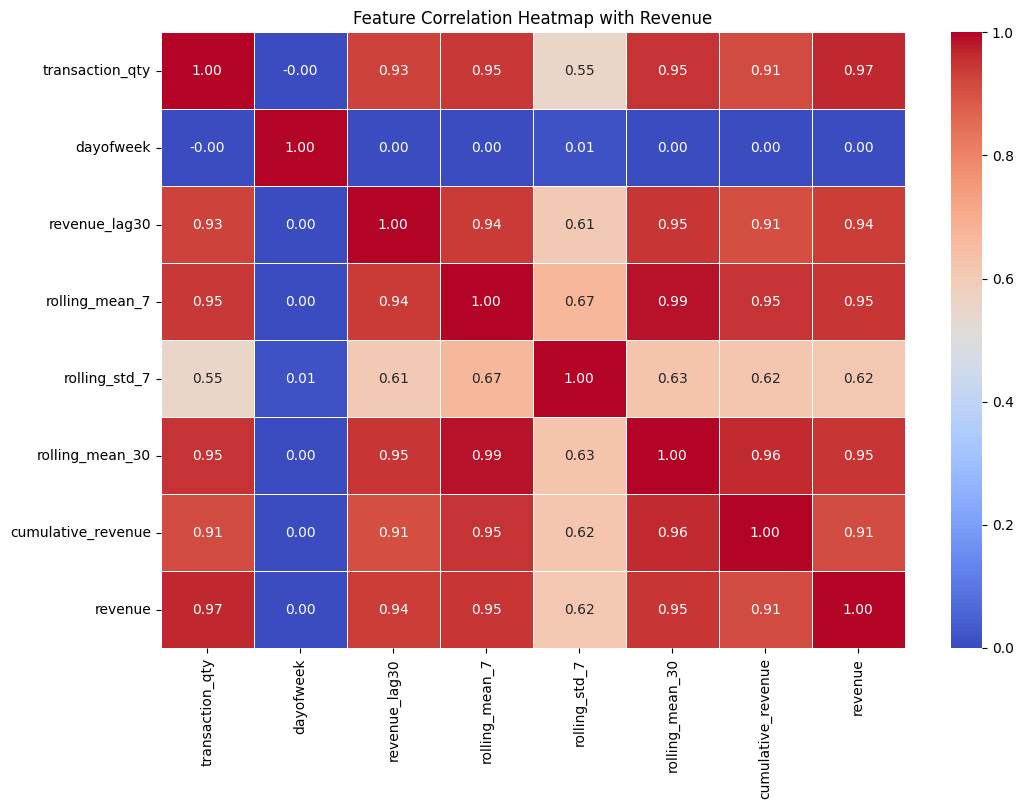

In [4]:
# Combine features and target into a single DataFrame
df_corr = df_segmented[features + [target]]

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap with Revenue")
plt.show()

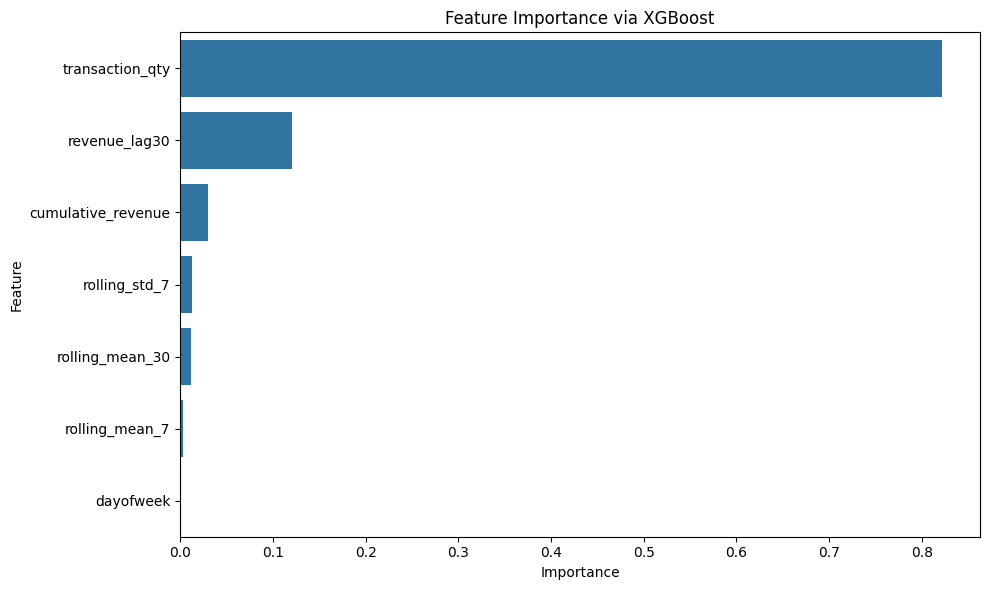

In [5]:
# Train an XGBoost model for feature importance
xgb = XGBRegressor()
xgb.fit(df_segmented[features], df_segmented[target])

# Get and plot feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title("Feature Importance via XGBoost")
plt.tight_layout()
plt.show()

Epoch 1/100


c:\Users\NARINDER\Desktop\forcasting_API\forcast\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0119 - mae: 0.1168 - val_loss: 0.0211 - val_mae: 0.1467 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0096 - mae: 0.1072 - val_loss: 0.0202 - val_mae: 0.1483 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - mae: 0.1096 - val_loss: 0.0208 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - mae: 0.1064 - val_loss: 0.0207 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - mae: 0.1087 - val_loss: 0.0204 - val_mae: 0.1478 - learning_rate: 0.0010
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - mae: 0.1082 - val_loss: 0.0213 - val_mae: 0.1463 - learning_rate: 0.0010
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0095 - mae: 0.1057 - val_loss: 0.0202 - val_mae: 0.1482 - learning_rate: 0.0010
Epoch 8/100
93/93 ━━━━━

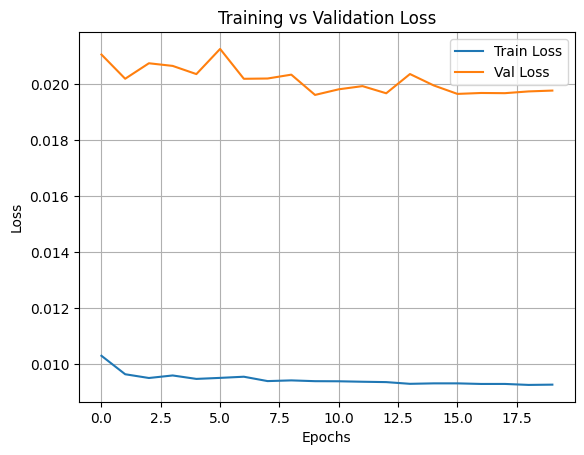

In [18]:
from tensorflow.keras.losses import huber, Huber

# Model Architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model with Huber loss (robust to outliers)
model.compile(
    optimizer='adam',
    loss=Huber(delta=1.0),
    metrics=['mae']
)
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
y_pred = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


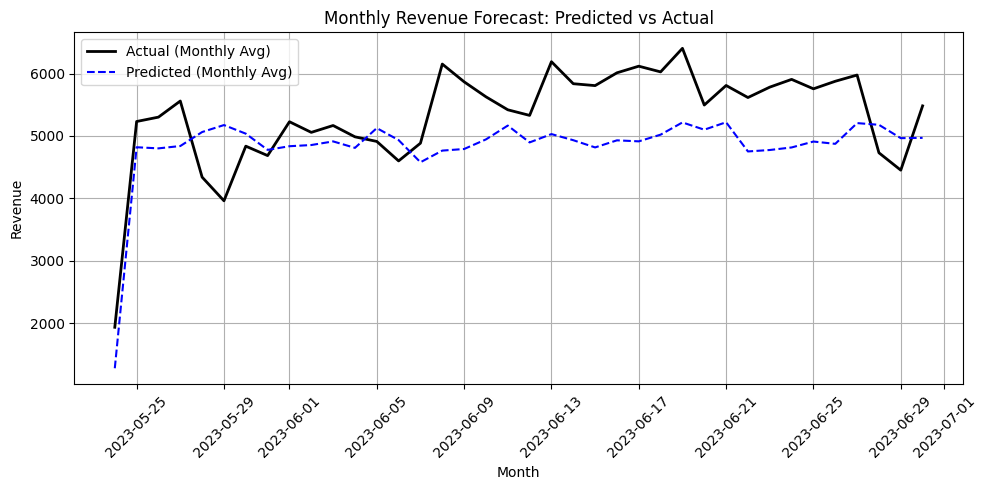

In [ ]:
# Inverse scale the predictions and true values
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

timestamps = df_segmented['timestamp'].values[sequence_length:]

# Now split the timestamps just like your X/y
_, timestamps_test = train_test_split(timestamps, test_size=0.25, shuffle=False)


# Step 1: Create a DataFrame for test results
results_df = pd.DataFrame({
    "timestamp": pd.to_datetime(timestamps_test),
    "actual": y_test_inv.flatten(),
    "predicted": y_pred_inv.flatten()
})

# Step 2: Set timestamp as index
results_df.set_index("timestamp", inplace=True)

# Step 3: Resample monthly (you can also use 'sum' if revenue is cumulative)
monthly_results = results_df.resample("D").sum()

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_results.index, monthly_results["actual"], label="Actual (Monthly Avg)", color='black', linewidth=2)
plt.plot(monthly_results.index, monthly_results["predicted"], label="Predicted (Monthly Avg)", color='blue', linestyle='--')
plt.title("Monthly Revenue Forecast: Predicted vs Actual")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



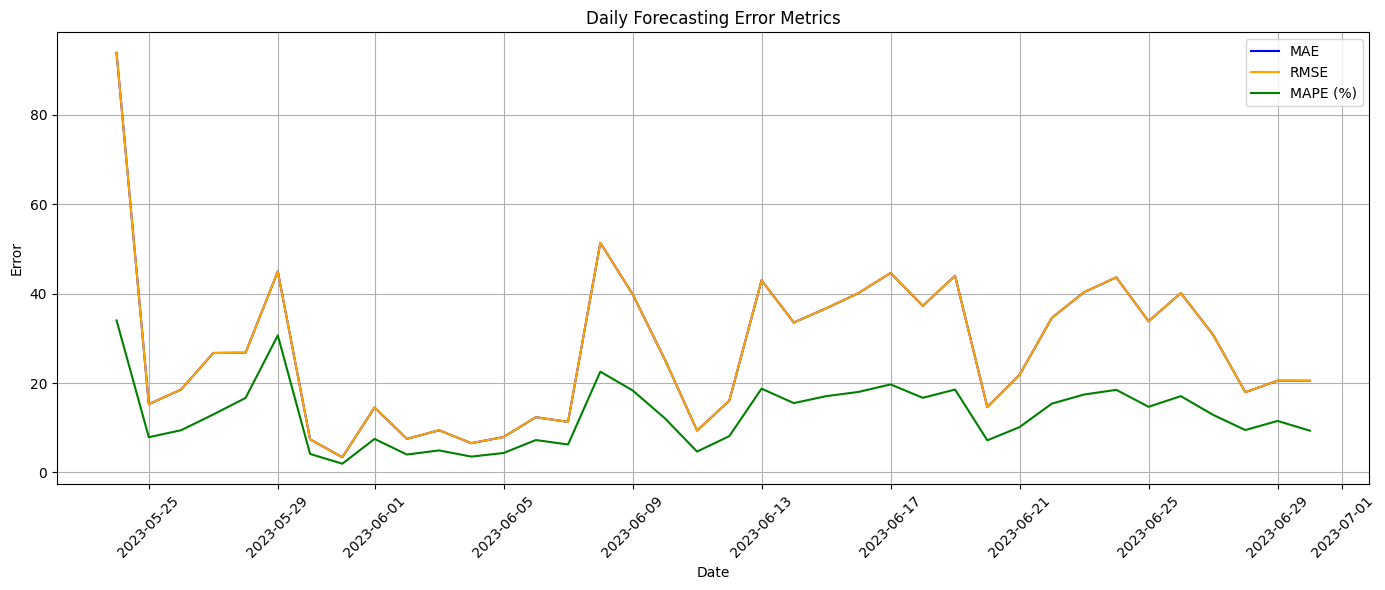

In [ ]:
# Create a DataFrame of predictions and actuals with timestamp
daily_df = pd.DataFrame({
    "timestamp": pd.to_datetime(timestamps_test),
    "actual": y_test_inv.flatten(),
    "predicted": y_pred_inv.flatten()
})

# Group by day (or keep daily if already per-day)
daily_grouped = daily_df.groupby("timestamp").agg({
    "actual": "mean",
    "predicted": "mean"
}).reset_index()

# Compute daily metrics
daily_grouped["mae"] = np.abs(daily_grouped["actual"] - daily_grouped["predicted"])
daily_grouped["mape"] = np.abs((daily_grouped["actual"] - daily_grouped["predicted"]) / daily_grouped["actual"]) * 100
daily_grouped["rmse"] = (daily_grouped["actual"] - daily_grouped["predicted"]) ** 2

# Finalize RMSE (take square root after grouping)
daily_grouped["rmse"] = daily_grouped["rmse"].apply(np.sqrt)

# Plot the daily metrics
plt.figure(figsize=(14, 6))
plt.plot(daily_grouped["timestamp"], daily_grouped["mae"], label="MAE", color="blue")
plt.plot(daily_grouped["timestamp"], daily_grouped["rmse"], label="RMSE", color="orange")
plt.plot(daily_grouped["timestamp"], daily_grouped["mape"], label="MAPE (%)", color="green")
plt.title("Daily Forecasting Error Metrics")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


_____________________________________________________________________________________________________________________